In [13]:
# Importing libraries 
import os
import json
import datetime
import numpy as np
import pandas as pd
import skimage.draw
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf 
from tqdm import tqdm 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import Mask RCNN
from mrcnn.visualize import display_instances
from mrcnn import model as modellib, utils
from mrcnn.config import Config
import mrcnn.mrcnnCustom as mrcnnCustom
import mrcnn.updatedUtils as updatedUtils

In [2]:
# Loading the dataset 
PATHS = {
    "root_dir": "",
    "checkpoint_path": "model/logs", 
    "trained_weights": "model/logs/petrol station20241001T2009/mask_rcnn_petrol station_0080.h5"
}

# Defining object name 
objectList = ["petrol station"]

In [3]:
class PredictionConfig(Config):
    NAME = "petrol station"
    
    # Max images per GPU in the testing phase is 1
    IMAGES_PER_GPU = 1

    # Background + object of interest
    NUM_CLASSES = 1 + 1     
    
    DETECTION_MIN_CONFIDENCE = 0.9

config_pred = PredictionConfig()

In [4]:
model = modellib.MaskRCNN(mode = "inference", model_dir=PATHS["checkpoint_path"], config=config_pred)
model.load_weights(PATHS["trained_weights"], by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








In [5]:
imagePath = "dataset"
imageSubFolder = "test"
imageList = os.listdir(imagePath)
dataset = mrcnnCustom.CustomDataset()
dataset.load_custom(imagePath, imageSubFolder, objectList)
dataset.prepare()

In [6]:
def occlusion_sensitivity(model, image, occlusion_size=20):
    height, width, _ = image.shape
    
    original_output = model.detect([image], verbose=0)[0]['masks']
    original_mask = (original_output[..., 0] > 0).astype(int) 
    occlusion_map = np.zeros((height, width))

    for i in tqdm(range(0, height, occlusion_size), desc="Processing Rows", ):
        for j in tqdm(range(0, width, occlusion_size), desc="Processing Columns"):
            occluded_image = np.copy(image)
            occluded_image[i:i + occlusion_size, j:j + occlusion_size, :] = 0
            occluded_output = model.detect([occluded_image], verbose=0)[0]['masks']
            occluded_mask = (occluded_output[..., 0] > 0).astype(int)  

            orig_slice = original_mask[i:i + occlusion_size, j:j + occlusion_size]
            occluded_slice = occluded_mask[:occlusion_size, :occlusion_size]  

            if orig_slice.shape == occluded_slice.shape:
                occlusion_diff = orig_slice != occluded_slice
                occlusion_map[i:i + occlusion_size, j:j + occlusion_size] = occlusion_diff.astype(int)

    return occlusion_map

In [18]:
occlusion_maps = []
images = [] 

for inspect_id in tqdm(dataset.image_ids, desc="Inspecting Images"): 
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config_pred, inspect_id)
    images.append(image)
    
    try: 
        occlusion_maps.append(occlusion_sensitivity(model, image))
    except: 
        occlusion_maps.append([])
        print(f"Encountered an issue generating the occlusion map for image {inspect_id}")

Processing Rows:   0%|                                                                          | 0/52 [00:00<?, ?it/s]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:46,  3.27s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:44,  3.30s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:39,  3.26s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:12<02:34,  3.22s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:30,  3.20s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:19<02:26,  3.19s/it]

Processing Columns:  13%|███████

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:58<01:50,  3.25s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:02<01:47,  3.24s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:05<01:43,  3.25s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:08<01:40,  3.24s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:11<01:37,  3.24s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:15<01:33,  3.23s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:18<01:30,  3.24s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:21<01:27,  3.23s/it]

Processing Columns:  50%|███████

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:05<00:50,  3.61s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:09<00:47,  3.63s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:13<00:43,  3.64s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:16<00:39,  3.58s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:19<00:34,  3.50s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:23<00:30,  3.44s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:26<00:27,  3.41s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:29<00:23,  3.37s/it]

Processing Columns:  88%|███████

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:44,  3.42s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:17<02:38,  3.38s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:20<02:34,  3.36s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:23<02:31,  3.37s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:27<02:27,  3.35s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:30<02:23,  3.35s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:33<02:20,  3.34s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:37<02:17,  3.34s/it]

Processing Columns:  23%|███████

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:21<01:34,  3.37s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:24<01:30,  3.36s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:28<01:27,  3.35s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:31<01:23,  3.35s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:34<01:20,  3.37s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:38<01:17,  3.36s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:41<01:14,  3.36s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:44<01:10,  3.36s/it]

Processing Columns:  62%|███████

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:29<00:27,  3.47s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:32<00:24,  3.44s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:36<00:20,  3.43s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:39<00:17,  3.43s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:42<00:13,  3.42s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:46<00:10,  3.39s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:49<00:06,  3.38s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:52<00:03,  3.36s/it]

Processing Columns: 100%|███████

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:33<02:21,  3.37s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:36<02:18,  3.37s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:40<02:14,  3.37s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:43<02:11,  3.36s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:47<02:07,  3.37s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:50<02:04,  3.37s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:53<02:01,  3.37s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:57<01:58,  3.38s/it]

Processing Columns:  35%|███████

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:41<01:15,  3.44s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:44<01:12,  3.48s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:48<01:08,  3.43s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:51<01:04,  3.41s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:54<01:01,  3.39s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:58<00:57,  3.39s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [02:01<00:53,  3.37s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:05<00:50,  3.37s/it]

Processing Columns:  73%|███████

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:48<00:06,  3.35s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:52<00:03,  3.35s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:55<00:00,  3.38s/it]

Processing Rows:  37%|██████████████████████▋                                       | 19/52 [55:09<1:36:39, 175.73s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:53,  3.39s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:49,  3.39s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:10<02:44,  3.36s/it]

Processing Columns:   8%|████▊  

Processing Columns:  31%|███████████████████                                           | 16/52 [00:53<02:01,  3.37s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:57<01:58,  3.39s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [01:00<01:56,  3.44s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:04<01:54,  3.46s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:07<01:52,  3.52s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:11<01:47,  3.47s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:14<01:43,  3.44s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:18<01:38,  3.41s/it]

Processing Columns:  46%|███████

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [02:01<00:53,  3.36s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:05<00:50,  3.35s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:08<00:46,  3.35s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:11<00:43,  3.36s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:15<00:40,  3.35s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:18<00:36,  3.36s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:22<00:33,  3.37s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:25<00:30,  3.37s/it]

Processing Columns:  85%|███████

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:47,  3.36s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:10<02:43,  3.34s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:40,  3.34s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:36,  3.34s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:20<02:35,  3.38s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:23<02:34,  3.43s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:27<02:32,  3.46s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:30<02:31,  3.52s/it]

Processing Columns:  19%|███████

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:14<01:41,  3.37s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:17<01:37,  3.38s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:21<01:33,  3.35s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:24<01:30,  3.35s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:27<01:27,  3.35s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:31<01:23,  3.35s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:34<01:20,  3.34s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:38<01:17,  3.39s/it]

Processing Columns:  58%|███████

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:21<00:33,  3.34s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:24<00:30,  3.34s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:28<00:26,  3.33s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:31<00:23,  3.35s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:34<00:20,  3.34s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:38<00:16,  3.37s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:41<00:13,  3.42s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:45<00:10,  3.44s/it]

Processing Columns:  96%|███████

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:26<02:27,  3.35s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:30<02:24,  3.35s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:33<02:20,  3.35s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:36<02:17,  3.34s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:40<02:13,  3.34s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:43<02:10,  3.34s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:46<02:06,  3.34s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:50<02:03,  3.34s/it]

Processing Columns:  31%|███████

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:33<01:19,  3.32s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:37<01:16,  3.32s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:40<01:13,  3.32s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:43<01:10,  3.34s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:47<01:06,  3.33s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:50<01:03,  3.34s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:53<01:00,  3.36s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:57<00:56,  3.35s/it]

Processing Columns:  69%|███████

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:40<00:13,  3.39s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:44<00:10,  3.37s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:47<00:06,  3.37s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:50<00:03,  3.35s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.35s/it]

Processing Rows:  73%|█████████████████████████████████████████████▎                | 38/52 [1:50:35<40:40, 174.29s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:49,  3.33s/it]

Processing Columns:   4%|██▍    

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:47<02:06,  3.34s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:50<02:03,  3.35s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:53<02:00,  3.35s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:57<01:57,  3.35s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [01:00<01:54,  3.36s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:03<01:50,  3.35s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:07<01:47,  3.35s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:10<01:44,  3.37s/it]

Processing Columns:  42%|███████

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:54<01:02,  3.45s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:57<00:57,  3.41s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [02:00<00:54,  3.38s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:03<00:50,  3.36s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:07<00:46,  3.34s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:10<00:43,  3.34s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:13<00:39,  3.33s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:17<00:36,  3.33s/it]

Processing Columns:  81%|███████

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:50,  3.34s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:48,  3.36s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:10<02:43,  3.34s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:40,  3.34s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:36,  3.33s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:20<02:33,  3.33s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:23<02:30,  3.33s/it]

Processing Columns:  15%|███████

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:06<01:46,  3.32s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:09<01:42,  3.32s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:13<01:39,  3.31s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:16<01:37,  3.37s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:20<01:35,  3.41s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:23<01:33,  3.45s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:27<01:28,  3.41s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:30<01:24,  3.39s/it]

Processing Columns:  54%|███████

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:13<00:40,  3.34s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:17<00:36,  3.35s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:20<00:33,  3.34s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:23<00:30,  3.34s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:27<00:26,  3.34s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:30<00:23,  3.32s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:33<00:19,  3.32s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:36<00:16,  3.31s/it]

Processing Columns:  92%|███████

Encountered an issue generating the occlusion map for image 1



Processing Rows:   0%|                                                                          | 0/52 [00:00<?, ?it/s]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:51,  3.35s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:46,  3.34s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:42,  3.32s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:38,  3.31s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:35,  3.31s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:19<02:32,  3.32s/it]

Processing Columns:  13%|██████

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:03<01:52,  3.41s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:06<01:48,  3.39s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:10<01:44,  3.37s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:13<01:41,  3.39s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:17<01:37,  3.36s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:20<01:34,  3.36s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:23<01:30,  3.35s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:26<01:26,  3.34s/it]

Processing Columns:  52%|███████

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:09<00:43,  3.33s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:13<00:39,  3.33s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:16<00:36,  3.34s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:19<00:33,  3.33s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:23<00:29,  3.33s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:26<00:26,  3.32s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:29<00:23,  3.32s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:33<00:19,  3.31s/it]

Processing Columns:  90%|███████

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:37,  3.34s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:20<02:33,  3.33s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:23<02:29,  3.32s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:26<02:29,  3.39s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:30<02:28,  3.45s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:33<02:24,  3.43s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:37<02:19,  3.39s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:40<02:15,  3.38s/it]

Processing Columns:  25%|███████

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:23<01:29,  3.33s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:27<01:26,  3.32s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:30<01:23,  3.32s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:33<01:19,  3.31s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:36<01:16,  3.31s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:40<01:12,  3.31s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:43<01:10,  3.33s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:46<01:06,  3.32s/it]

Processing Columns:  63%|███████

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:30<00:23,  3.34s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:33<00:20,  3.34s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:36<00:16,  3.34s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:40<00:13,  3.33s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:43<00:09,  3.33s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:46<00:06,  3.33s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:50<00:03,  3.36s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.34s/it]

Processing Rows:  23%|██████████

Processing Columns:  21%|█████████████                                                 | 11/52 [00:37<02:18,  3.38s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:40<02:15,  3.38s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:44<02:11,  3.36s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:47<02:07,  3.36s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:50<02:04,  3.36s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:54<02:00,  3.35s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:57<01:57,  3.35s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [01:00<01:53,  3.34s/it]

Processing Columns:  37%|███████

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:43<01:09,  3.33s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:46<01:06,  3.33s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:50<01:03,  3.32s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:53<00:59,  3.33s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:56<00:56,  3.34s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [02:00<00:53,  3.32s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:03<00:49,  3.32s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:06<00:46,  3.31s/it]

Processing Columns:  75%|███████

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:50<00:03,  3.37s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.34s/it]

Processing Rows:  37%|██████████████████████▋                                       | 19/52 [55:00<1:35:40, 173.94s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:49,  3.32s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:45,  3.31s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:10<02:43,  3.35s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:39,  3.33s/it]

Processing Columns:  10%|██████ 

Encountered an issue generating the occlusion map for image 2



Processing Rows:   0%|                                                                          | 0/52 [00:00<?, ?it/s]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:56,  3.47s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:50,  3.41s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:10<02:44,  3.36s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:39,  3.33s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:35,  3.31s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:20<02:32,  3.32s/it]

Processing Columns:  13%|██████

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:03<01:49,  3.32s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:06<01:46,  3.32s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:10<01:43,  3.33s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:13<01:39,  3.32s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:16<01:36,  3.31s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:20<01:33,  3.32s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:23<01:29,  3.32s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:26<01:26,  3.31s/it]

Processing Columns:  52%|███████

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:10<00:43,  3.33s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:13<00:39,  3.32s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:16<00:36,  3.34s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:20<00:33,  3.32s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:23<00:29,  3.31s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:26<00:26,  3.36s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:30<00:23,  3.38s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:33<00:20,  3.42s/it]

Processing Columns:  90%|███████

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:35,  3.31s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:19<02:33,  3.35s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:23<02:29,  3.32s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:26<02:26,  3.32s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:29<02:22,  3.31s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:33<02:18,  3.31s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:36<02:15,  3.30s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:39<02:11,  3.30s/it]

Processing Columns:  25%|███████

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:23<01:30,  3.33s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:26<01:26,  3.33s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:30<01:23,  3.34s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:33<01:20,  3.34s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:36<01:16,  3.33s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:40<01:12,  3.32s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:43<01:09,  3.31s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:46<01:06,  3.31s/it]

Processing Columns:  63%|███████

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:29<00:23,  3.35s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:32<00:20,  3.35s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:36<00:16,  3.33s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:39<00:13,  3.31s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:42<00:09,  3.32s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:46<00:06,  3.31s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:49<00:03,  3.32s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:52<00:00,  3.32s/it]

Processing Rows:  23%|██████████

Processing Columns:  21%|█████████████                                                 | 11/52 [00:36<02:15,  3.31s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:39<02:12,  3.32s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:43<02:09,  3.31s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:46<02:05,  3.30s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:49<02:02,  3.32s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:53<01:59,  3.31s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:56<01:55,  3.31s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:59<01:52,  3.31s/it]

Processing Columns:  37%|███████

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:42<01:09,  3.32s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:46<01:06,  3.32s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:49<01:04,  3.38s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:53<01:01,  3.41s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:56<00:58,  3.44s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [01:59<00:54,  3.39s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:03<00:50,  3.35s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:06<00:46,  3.35s/it]

Processing Columns:  75%|███████

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:50<00:03,  3.32s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.35s/it]

Processing Rows:  37%|██████████████████████▋                                       | 19/52 [54:49<1:35:21, 173.38s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:48,  3.31s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:45,  3.31s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:41,  3.29s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:38,  3.30s/it]

Processing Columns:  10%|██████ 

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:56<01:56,  3.32s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:59<01:52,  3.32s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:03<01:49,  3.31s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:06<01:46,  3.31s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:09<01:42,  3.31s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:13<01:39,  3.31s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:16<01:36,  3.31s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:19<01:33,  3.35s/it]

Processing Columns:  48%|███████

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:07<00:51,  3.46s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:11<00:48,  3.48s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:15<00:45,  3.53s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:18<00:42,  3.51s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:21<00:38,  3.48s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:25<00:34,  3.48s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:28<00:31,  3.47s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:32<00:27,  3.47s/it]

Processing Columns:  87%|███████

Processing Columns:   6%|███▋                                                           | 3/52 [00:10<02:51,  3.49s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:46,  3.47s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:17<02:43,  3.49s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:20<02:40,  3.49s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:24<02:37,  3.51s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:28<02:35,  3.53s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:31<02:33,  3.56s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:35<02:29,  3.57s/it]

Processing Columns:  21%|███████

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:17<01:37,  3.36s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:21<01:34,  3.38s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:24<01:30,  3.36s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:27<01:27,  3.37s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:31<01:24,  3.38s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:34<01:21,  3.38s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:37<01:17,  3.36s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:41<01:13,  3.36s/it]

Processing Columns:  60%|███████

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:24<00:30,  3.34s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:27<00:26,  3.34s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:31<00:23,  3.34s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:34<00:20,  3.34s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:37<00:16,  3.33s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:41<00:13,  3.33s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:44<00:09,  3.33s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:47<00:06,  3.34s/it]

Processing Columns:  98%|███████

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:30<02:24,  3.37s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:33<02:21,  3.36s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:37<02:17,  3.36s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:40<02:13,  3.34s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:43<02:10,  3.34s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:47<02:06,  3.33s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:50<02:03,  3.33s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:53<02:00,  3.35s/it]

Processing Columns:  33%|███████

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:36<01:16,  3.32s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:39<01:13,  3.32s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:43<01:09,  3.33s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:46<01:06,  3.32s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:49<01:02,  3.31s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:53<00:59,  3.31s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:56<00:56,  3.31s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [01:59<00:52,  3.31s/it]

Processing Columns:  71%|███████

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:43<00:10,  3.36s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:47<00:06,  3.34s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:50<00:03,  3.33s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.34s/it]

Processing Rows:  73%|█████████████████████████████████████████████▎                | 38/52 [1:50:21<40:35, 173.97s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:50,  3.34s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:48,  3.37s/it]

Processing Columns:   6%|███▋   

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:49<02:03,  3.33s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:53<01:59,  3.33s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:56<01:56,  3.34s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:59<01:52,  3.32s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:03<01:49,  3.33s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:06<01:46,  3.33s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:09<01:43,  3.32s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:13<01:39,  3.32s/it]

Processing Columns:  44%|███████

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:56<00:56,  3.31s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [02:00<00:53,  3.32s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:03<00:50,  3.37s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:07<00:47,  3.40s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:10<00:44,  3.42s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:13<00:40,  3.40s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:17<00:37,  3.37s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:20<00:33,  3.37s/it]

Processing Columns:  83%|███████

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:48,  3.31s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:46,  3.34s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:10<02:47,  3.41s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:41,  3.37s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:37,  3.36s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:20<02:33,  3.33s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:23<02:29,  3.32s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:26<02:26,  3.32s/it]

Processing Columns:  17%|███████

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:09<01:43,  3.33s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:13<01:39,  3.31s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:16<01:36,  3.32s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:19<01:32,  3.32s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:23<01:29,  3.32s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:26<01:26,  3.32s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:29<01:22,  3.32s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:33<01:20,  3.36s/it]

Processing Columns:  56%|███████

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:16<00:36,  3.33s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:20<00:33,  3.33s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:23<00:30,  3.34s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:26<00:26,  3.32s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:30<00:23,  3.33s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:33<00:19,  3.32s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:36<00:16,  3.32s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:40<00:13,  3.32s/it]

Processing Columns:  94%|███████

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:35,  3.32s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:19<02:32,  3.31s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:23<02:28,  3.30s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:26<02:24,  3.29s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:29<02:21,  3.29s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:32<02:18,  3.29s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:36<02:14,  3.29s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:39<02:12,  3.30s/it]

Processing Columns:  25%|███████

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:23<01:32,  3.41s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:26<01:27,  3.37s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:30<01:23,  3.36s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:33<01:20,  3.35s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:36<01:16,  3.34s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:40<01:13,  3.35s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:43<01:10,  3.35s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:47<01:06,  3.34s/it]

Processing Columns:  63%|███████

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:29<00:23,  3.34s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:33<00:19,  3.33s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:36<00:16,  3.31s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:39<00:13,  3.31s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:43<00:09,  3.32s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:46<00:06,  3.33s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:49<00:03,  3.32s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:52<00:00,  3.33s/it]

Processing Rows:  10%|██████    

Processing Columns:  21%|█████████████                                                 | 11/52 [00:36<02:17,  3.35s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:40<02:15,  3.38s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:43<02:13,  3.41s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:46<02:10,  3.43s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:50<02:08,  3.47s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:53<02:04,  3.46s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:57<01:59,  3.42s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [01:00<01:54,  3.38s/it]

Processing Columns:  37%|███████

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:43<01:10,  3.35s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:47<01:06,  3.33s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:50<01:03,  3.33s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:53<00:59,  3.33s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:57<00:56,  3.33s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [02:00<00:53,  3.33s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:03<00:49,  3.33s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:07<00:46,  3.32s/it]

Processing Columns:  75%|███████

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:50<00:03,  3.32s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.34s/it]

Processing Rows:  23%|██████████████▎                                               | 12/52 [34:44<1:55:54, 173.86s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:49,  3.33s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:46,  3.34s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:42,  3.32s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:39,  3.33s/it]

Processing Columns:  10%|██████ 

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:57<01:57,  3.35s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [01:00<01:54,  3.37s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:04<01:50,  3.36s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:07<01:47,  3.36s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:10<01:43,  3.34s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:14<01:40,  3.35s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:17<01:37,  3.35s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:20<01:34,  3.36s/it]

Processing Columns:  48%|███████

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [02:03<00:49,  3.31s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:06<00:46,  3.31s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:09<00:43,  3.31s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:13<00:39,  3.32s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:16<00:36,  3.32s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:19<00:33,  3.31s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:23<00:29,  3.31s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:26<00:26,  3.31s/it]

Processing Columns:  87%|███████

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:41,  3.31s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:13<02:39,  3.33s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:16<02:35,  3.32s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:19<02:32,  3.32s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:23<02:29,  3.32s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:26<02:26,  3.33s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:29<02:23,  3.33s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:33<02:19,  3.33s/it]

Processing Columns:  21%|███████

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:17<01:36,  3.34s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:20<01:33,  3.34s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:24<01:30,  3.35s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:27<01:27,  3.36s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:31<01:23,  3.35s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:34<01:19,  3.33s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:37<01:16,  3.33s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:40<01:13,  3.34s/it]

Processing Columns:  60%|███████

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:24<00:30,  3.43s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:28<00:27,  3.47s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:31<00:23,  3.42s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:34<00:20,  3.41s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:38<00:17,  3.40s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:41<00:13,  3.37s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:44<00:10,  3.34s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:48<00:06,  3.35s/it]

Processing Columns:  98%|███████

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:30<02:24,  3.37s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:33<02:21,  3.37s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:37<02:18,  3.37s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:40<02:14,  3.37s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:43<02:11,  3.37s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:47<02:07,  3.36s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:50<02:04,  3.35s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:53<02:00,  3.36s/it]

Processing Columns:  33%|███████

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:37<01:17,  3.36s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:40<01:13,  3.35s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:44<01:10,  3.37s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:47<01:07,  3.40s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:50<01:04,  3.42s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:54<01:02,  3.46s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:57<00:58,  3.41s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [02:01<00:54,  3.43s/it]

Processing Columns:  71%|███████

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:45<00:10,  3.36s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:49<00:06,  3.37s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:52<00:03,  3.36s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:55<00:00,  3.38s/it]

Processing Rows:  60%|███████████████████████████████████▊                        | 31/52 [1:30:01<1:01:22, 175.38s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:50,  3.35s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:50,  3.40s/it]

Processing Columns:   6%|███▋   

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:54<02:14,  3.63s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:58<02:10,  3.63s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [01:01<02:06,  3.61s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [01:05<02:00,  3.55s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [01:08<01:56,  3.53s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:12<01:53,  3.54s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:15<01:49,  3.53s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:19<01:45,  3.51s/it]

Processing Columns:  44%|███████

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:48<00:52,  3.11s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [01:51<00:49,  3.10s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [01:54<00:46,  3.10s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [01:57<00:43,  3.08s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:00<00:39,  3.07s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:04<00:36,  3.07s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:07<00:33,  3.06s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:10<00:30,  3.06s/it]

Processing Columns:  83%|███████

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:35,  3.04s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:31,  3.04s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:29,  3.06s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:12<02:26,  3.06s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:15<02:23,  3.06s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:18<02:20,  3.05s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:21<02:17,  3.05s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:24<02:14,  3.05s/it]

Processing Columns:  17%|███████

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:05<01:35,  3.09s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:08<01:32,  3.09s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:11<01:29,  3.08s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:14<01:25,  3.06s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:17<01:23,  3.09s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:20<01:20,  3.08s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:23<01:17,  3.08s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:26<01:13,  3.07s/it]

Processing Columns:  56%|███████

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:06<00:33,  3.06s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:09<00:31,  3.11s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:12<00:27,  3.10s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:16<00:24,  3.10s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:19<00:21,  3.10s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:22<00:18,  3.08s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:25<00:15,  3.08s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:28<00:12,  3.09s/it]

Processing Columns:  94%|███████

Processing Columns:  13%|████████▍                                                      | 7/52 [00:21<02:18,  3.09s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:24<02:15,  3.08s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:27<02:12,  3.07s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:30<02:08,  3.06s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:33<02:05,  3.06s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:36<02:03,  3.08s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:40<02:00,  3.10s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:43<01:59,  3.14s/it]

Processing Columns:  29%|███████

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:23<01:19,  3.19s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:27<01:16,  3.18s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:30<01:12,  3.16s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:33<01:08,  3.13s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:36<01:05,  3.12s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:39<01:01,  3.09s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:42<00:58,  3.10s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:45<00:55,  3.10s/it]

Processing Columns:  67%|███████

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:26<00:15,  3.11s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:29<00:12,  3.11s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:32<00:09,  3.11s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:35<00:06,  3.12s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:38<00:03,  3.10s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:41<00:00,  3.11s/it]

Processing Rows:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [2:21:47<05:22, 161.42s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏     

Processing Columns:  21%|█████████████                                                 | 11/52 [00:33<02:05,  3.07s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:36<02:02,  3.07s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:40<01:59,  3.07s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:43<01:57,  3.08s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:46<01:54,  3.10s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:49<01:51,  3.09s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:52<01:48,  3.09s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:55<01:45,  3.09s/it]

Processing Columns:  37%|███████

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:35<01:04,  3.09s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:39<01:01,  3.09s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:42<00:58,  3.09s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:45<00:55,  3.08s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:48<00:52,  3.08s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [01:51<00:49,  3.07s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [01:54<00:46,  3.08s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [01:57<00:43,  3.09s/it]

Processing Columns:  75%|███████

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:38<00:03,  3.09s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:41<00:00,  3.10s/it]

Processing Rows:  10%|██████                                                         | 5/52 [13:24<2:06:06, 160.99s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:36,  3.07s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:34,  3.08s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:30,  3.07s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:12<02:27,  3.08s/it]

Processing Columns:  10%|██████ 

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:52<01:48,  3.10s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:55<01:45,  3.09s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [00:58<01:42,  3.09s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:01<01:40,  3.14s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:05<01:37,  3.16s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:08<01:35,  3.19s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:11<01:31,  3.17s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:14<01:28,  3.15s/it]

Processing Columns:  48%|███████

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [01:55<00:46,  3.12s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [01:58<00:43,  3.10s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:01<00:40,  3.10s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:04<00:37,  3.10s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:07<00:34,  3.09s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:10<00:31,  3.10s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:13<00:27,  3.11s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:16<00:24,  3.09s/it]

Processing Columns:  87%|███████

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:32,  3.11s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:12<02:29,  3.11s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:15<02:25,  3.11s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:18<02:23,  3.11s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:21<02:19,  3.10s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:24<02:16,  3.09s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:27<02:12,  3.09s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:30<02:09,  3.09s/it]

Processing Columns:  21%|███████

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:11<01:30,  3.10s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:14<01:26,  3.11s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:17<01:23,  3.09s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:20<01:20,  3.11s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:24<01:18,  3.12s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:27<01:14,  3.11s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:30<01:11,  3.10s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:33<01:08,  3.10s/it]

Processing Columns:  60%|███████

Encountered an issue generating the occlusion map for image 5



Processing Rows:   0%|                                                                          | 0/52 [00:00<?, ?it/s]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:36,  3.07s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:34,  3.08s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:31,  3.08s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:12<02:27,  3.08s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:15<02:24,  3.08s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:18<02:22,  3.09s/it]

Processing Columns:  13%|██████

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [00:59<01:42,  3.12s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:02<01:39,  3.11s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:05<01:36,  3.10s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:08<01:33,  3.10s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:11<01:29,  3.08s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:14<01:25,  3.07s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:17<01:22,  3.07s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:20<01:19,  3.08s/it]

Processing Columns:  52%|███████

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:00<00:39,  3.07s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:03<00:36,  3.08s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:06<00:33,  3.08s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:09<00:30,  3.09s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:12<00:27,  3.09s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:15<00:24,  3.09s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:18<00:21,  3.08s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:22<00:18,  3.09s/it]

Processing Columns:  90%|███████

Processing Columns:  10%|██████                                                         | 5/52 [00:15<02:27,  3.13s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:18<02:23,  3.11s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:21<02:19,  3.10s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:24<02:16,  3.10s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:27<02:12,  3.09s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:31<02:10,  3.12s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:34<02:07,  3.12s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:37<02:04,  3.11s/it]

Processing Columns:  25%|███████

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:17<01:23,  3.09s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:20<01:19,  3.07s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:23<01:18,  3.12s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:26<01:15,  3.15s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:29<01:13,  3.18s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:32<01:09,  3.14s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:36<01:05,  3.13s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:39<01:02,  3.12s/it]

Processing Columns:  63%|███████

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:19<00:21,  3.12s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:22<00:18,  3.11s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:26<00:15,  3.11s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:29<00:12,  3.10s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:32<00:09,  3.11s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:35<00:06,  3.11s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:38<00:03,  3.10s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:41<00:00,  3.11s/it]

Processing Rows:  23%|██████████

Processing Columns:  21%|█████████████                                                 | 11/52 [00:34<02:06,  3.09s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:37<02:03,  3.10s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:40<02:00,  3.09s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:43<01:57,  3.09s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:46<01:53,  3.08s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:49<01:51,  3.08s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:52<01:47,  3.08s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:55<01:45,  3.10s/it]

Processing Columns:  37%|███████

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:36<01:05,  3.12s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:39<01:02,  3.11s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:42<00:58,  3.10s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:46<00:55,  3.10s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:49<00:52,  3.11s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [01:52<00:49,  3.11s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [01:55<00:46,  3.10s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [01:58<00:43,  3.10s/it]

Processing Columns:  75%|███████

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:37<00:03,  3.07s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:40<00:00,  3.10s/it]

Processing Rows:  37%|██████████████████████▋                                       | 19/52 [51:05<1:28:41, 161.24s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:38,  3.11s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:34,  3.09s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:31,  3.09s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:12<02:28,  3.09s/it]

Processing Columns:  10%|██████ 

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:52<01:47,  3.07s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:55<01:44,  3.06s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [00:58<01:40,  3.06s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:01<01:38,  3.07s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:04<01:35,  3.08s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:08<01:34,  3.15s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:11<01:32,  3.17s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:14<01:28,  3.17s/it]

Processing Columns:  48%|███████

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [01:54<00:47,  3.17s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [01:58<00:44,  3.14s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:01<00:40,  3.13s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:04<00:37,  3.11s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:07<00:33,  3.09s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:10<00:30,  3.10s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:13<00:27,  3.10s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:16<00:24,  3.11s/it]

Processing Columns:  87%|███████

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:32,  3.10s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:12<02:28,  3.10s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:15<02:25,  3.10s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:18<02:22,  3.10s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:21<02:19,  3.11s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:24<02:16,  3.10s/it]

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:27<02:13,  3.10s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:31<02:10,  3.10s/it]

Processing Columns:  21%|███████

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:11<01:30,  3.11s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:14<01:26,  3.09s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:17<01:23,  3.09s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:20<01:20,  3.09s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:23<01:17,  3.09s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:26<01:14,  3.09s/it]

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:29<01:11,  3.09s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:33<01:08,  3.11s/it]

Processing Columns:  60%|███████

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:13<00:27,  3.08s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:16<00:24,  3.09s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:19<00:21,  3.08s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:22<00:18,  3.09s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:25<00:15,  3.09s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:28<00:12,  3.10s/it]

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:31<00:09,  3.08s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:34<00:06,  3.07s/it]

Processing Columns:  98%|███████

Processing Columns:  17%|██████████▉                                                    | 9/52 [00:27<02:12,  3.08s/it]

Processing Columns:  19%|███████████▉                                                  | 10/52 [00:30<02:10,  3.11s/it]

Processing Columns:  21%|█████████████                                                 | 11/52 [00:33<02:07,  3.10s/it]

Processing Columns:  23%|██████████████▎                                               | 12/52 [00:37<02:03,  3.10s/it]

Processing Columns:  25%|███████████████▌                                              | 13/52 [00:40<02:01,  3.11s/it]

Processing Columns:  27%|████████████████▋                                             | 14/52 [00:43<01:57,  3.10s/it]

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:46<01:54,  3.10s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:49<01:51,  3.10s/it]

Processing Columns:  33%|███████

Processing Columns:  56%|██████████████████████████████████▌                           | 29/52 [01:29<01:12,  3.13s/it]

Processing Columns:  58%|███████████████████████████████████▊                          | 30/52 [01:33<01:09,  3.16s/it]

Processing Columns:  60%|████████████████████████████████████▉                         | 31/52 [01:36<01:06,  3.19s/it]

Processing Columns:  62%|██████████████████████████████████████▏                       | 32/52 [01:39<01:03,  3.16s/it]

Processing Columns:  63%|███████████████████████████████████████▎                      | 33/52 [01:42<00:59,  3.13s/it]

Processing Columns:  65%|████████████████████████████████████████▌                     | 34/52 [01:45<00:56,  3.13s/it]

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:48<00:52,  3.11s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [01:51<00:49,  3.10s/it]

Processing Columns:  71%|███████

Processing Columns:  94%|██████████████████████████████████████████████████████████▍   | 49/52 [02:31<00:09,  3.12s/it]

Processing Columns:  96%|███████████████████████████████████████████████████████████▌  | 50/52 [02:34<00:06,  3.11s/it]

Processing Columns:  98%|████████████████████████████████████████████████████████████▊ | 51/52 [02:38<00:03,  3.10s/it]

Processing Columns: 100%|██████████████████████████████████████████████████████████████| 52/52 [02:41<00:00,  3.10s/it]

Processing Rows:  73%|█████████████████████████████████████████████▎                | 38/52 [1:42:09<37:37, 161.23s/it]

Processing Columns:   0%|                                                                       | 0/52 [00:00<?, ?it/s]

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:35,  3.05s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:33,  3.06s/it]

Processing Columns:   6%|███▋   

Processing Columns:  29%|█████████████████▉                                            | 15/52 [00:46<01:54,  3.09s/it]

Processing Columns:  31%|███████████████████                                           | 16/52 [00:49<01:51,  3.09s/it]

Processing Columns:  33%|████████████████████▎                                         | 17/52 [00:52<01:48,  3.11s/it]

Processing Columns:  35%|█████████████████████▍                                        | 18/52 [00:55<01:45,  3.11s/it]

Processing Columns:  37%|██████████████████████▋                                       | 19/52 [00:59<01:42,  3.11s/it]

Processing Columns:  38%|███████████████████████▊                                      | 20/52 [01:02<01:39,  3.10s/it]

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:05<01:36,  3.10s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:08<01:32,  3.10s/it]

Processing Columns:  44%|███████

Processing Columns:  67%|█████████████████████████████████████████▋                    | 35/52 [01:51<00:55,  3.27s/it]

Processing Columns:  69%|██████████████████████████████████████████▉                   | 36/52 [01:54<00:52,  3.30s/it]

Processing Columns:  71%|████████████████████████████████████████████                  | 37/52 [01:57<00:49,  3.32s/it]

Processing Columns:  73%|█████████████████████████████████████████████▎                | 38/52 [02:01<00:46,  3.29s/it]

Processing Columns:  75%|██████████████████████████████████████████████▌               | 39/52 [02:04<00:42,  3.28s/it]

Processing Columns:  77%|███████████████████████████████████████████████▋              | 40/52 [02:07<00:39,  3.26s/it]

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:10<00:35,  3.25s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:14<00:32,  3.25s/it]

Processing Columns:  83%|███████

Processing Columns:   2%|█▏                                                             | 1/52 [00:03<02:36,  3.06s/it]

Processing Columns:   4%|██▍                                                            | 2/52 [00:06<02:34,  3.09s/it]

Processing Columns:   6%|███▋                                                           | 3/52 [00:09<02:31,  3.09s/it]

Processing Columns:   8%|████▊                                                          | 4/52 [00:12<02:28,  3.09s/it]

Processing Columns:  10%|██████                                                         | 5/52 [00:15<02:25,  3.09s/it]

Processing Columns:  12%|███████▎                                                       | 6/52 [00:18<02:22,  3.10s/it]

Processing Columns:  13%|████████▍                                                      | 7/52 [00:21<02:18,  3.09s/it]

Processing Columns:  15%|█████████▋                                                     | 8/52 [00:24<02:16,  3.09s/it]

Processing Columns:  17%|███████

Processing Columns:  40%|█████████████████████████                                     | 21/52 [01:04<01:36,  3.11s/it]

Processing Columns:  42%|██████████████████████████▏                                   | 22/52 [01:07<01:34,  3.14s/it]

Processing Columns:  44%|███████████████████████████▍                                  | 23/52 [01:11<01:31,  3.17s/it]

Processing Columns:  46%|████████████████████████████▌                                 | 24/52 [01:14<01:28,  3.15s/it]

Processing Columns:  48%|█████████████████████████████▊                                | 25/52 [01:17<01:24,  3.12s/it]

Processing Columns:  50%|███████████████████████████████                               | 26/52 [01:20<01:21,  3.12s/it]

Processing Columns:  52%|████████████████████████████████▏                             | 27/52 [01:23<01:17,  3.11s/it]

Processing Columns:  54%|█████████████████████████████████▍                            | 28/52 [01:26<01:14,  3.10s/it]

Processing Columns:  56%|███████

Processing Columns:  79%|████████████████████████████████████████████████▉             | 41/52 [02:06<00:33,  3.08s/it]

Processing Columns:  81%|██████████████████████████████████████████████████            | 42/52 [02:09<00:30,  3.08s/it]

Processing Columns:  83%|███████████████████████████████████████████████████▎          | 43/52 [02:12<00:27,  3.07s/it]

Processing Columns:  85%|████████████████████████████████████████████████████▍         | 44/52 [02:15<00:24,  3.08s/it]

Processing Columns:  87%|█████████████████████████████████████████████████████▋        | 45/52 [02:18<00:21,  3.08s/it]

Processing Columns:  88%|██████████████████████████████████████████████████████▊       | 46/52 [02:21<00:18,  3.07s/it]

Processing Columns:  90%|████████████████████████████████████████████████████████      | 47/52 [02:24<00:15,  3.08s/it]

Processing Columns:  92%|█████████████████████████████████████████████████████████▏    | 48/52 [02:27<00:12,  3.07s/it]

Processing Columns:  94%|███████

In [19]:
def plot_occlusion_maps(image, occlusion_map):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(occlusion_map, cmap='hot', interpolation='nearest')
    plt.title('Occlusion Sensitivity Map')
    plt.colorbar()

    plt.tight_layout()  
    plt.show()

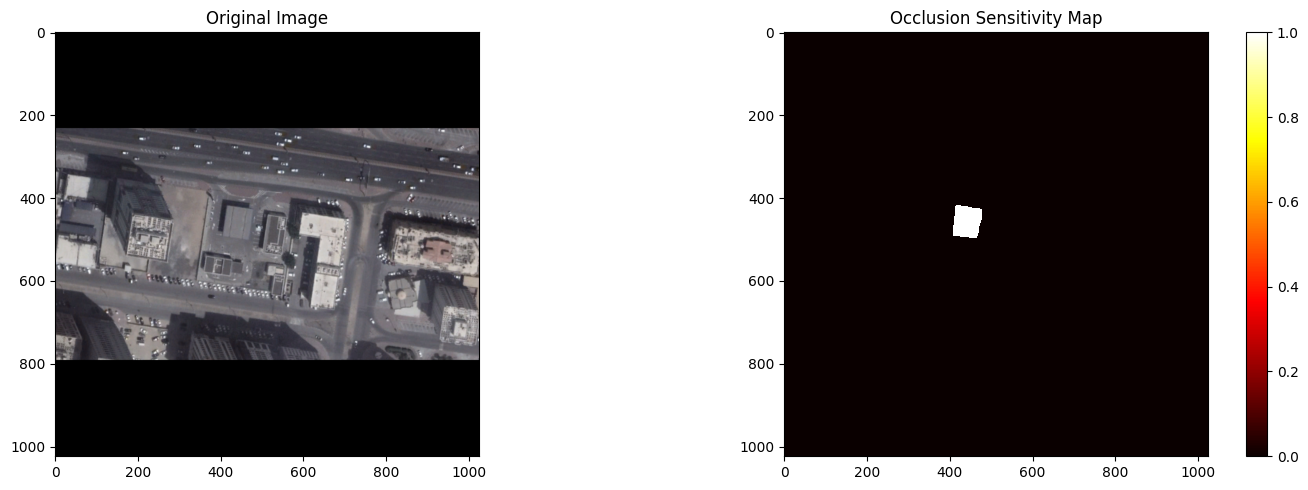

Oops
Oops


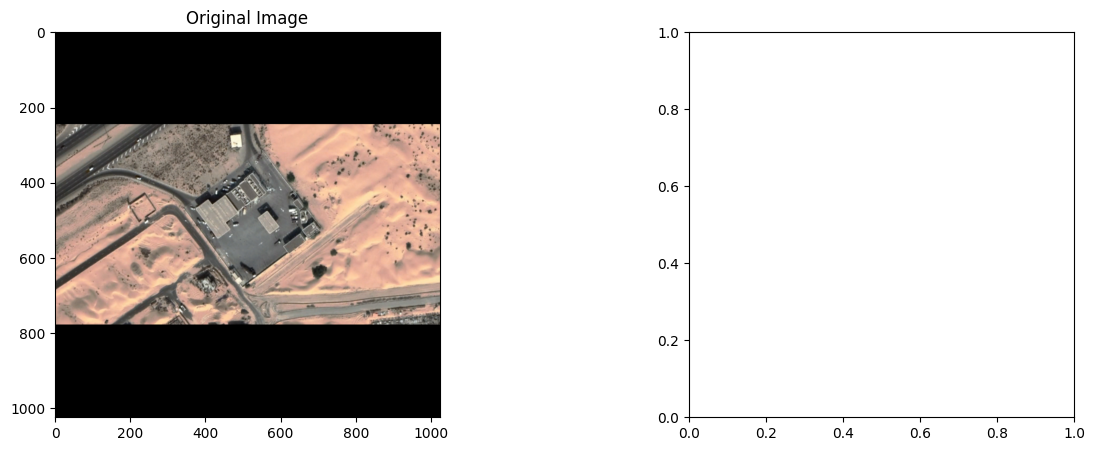

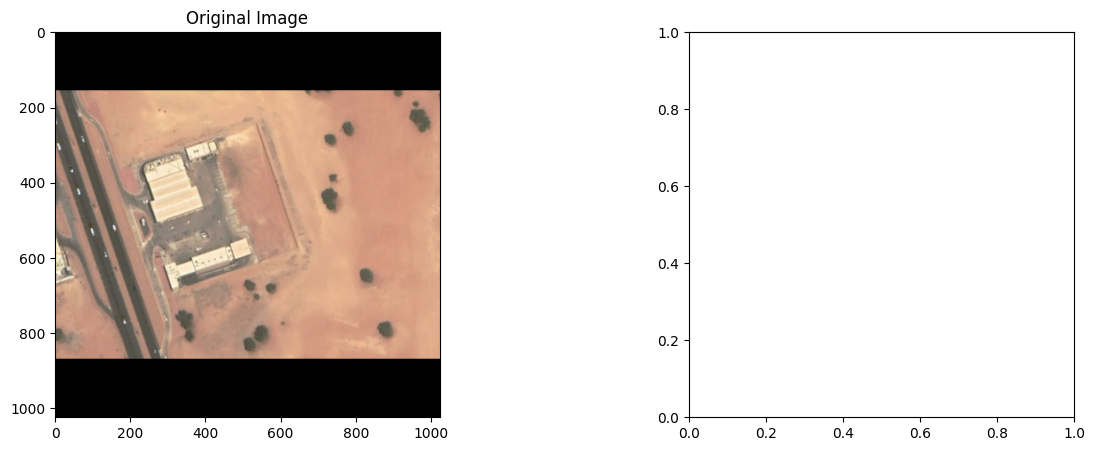

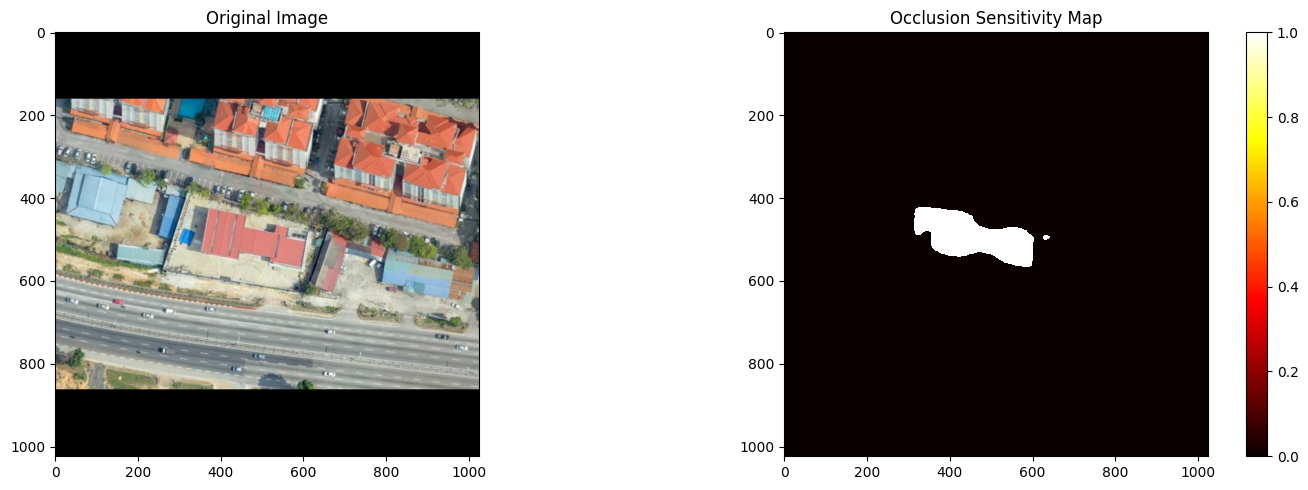

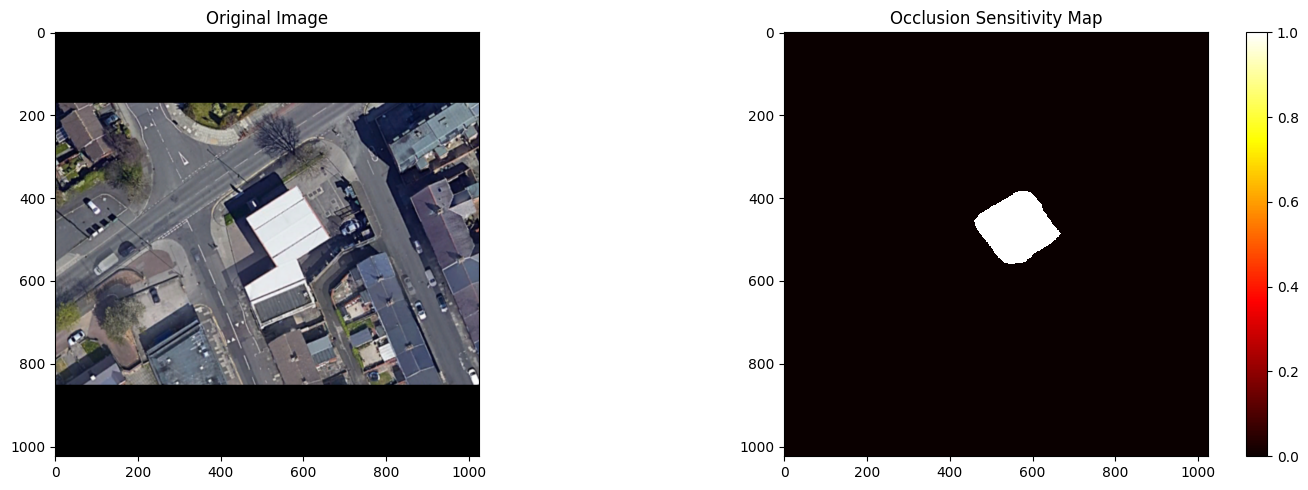

Oops


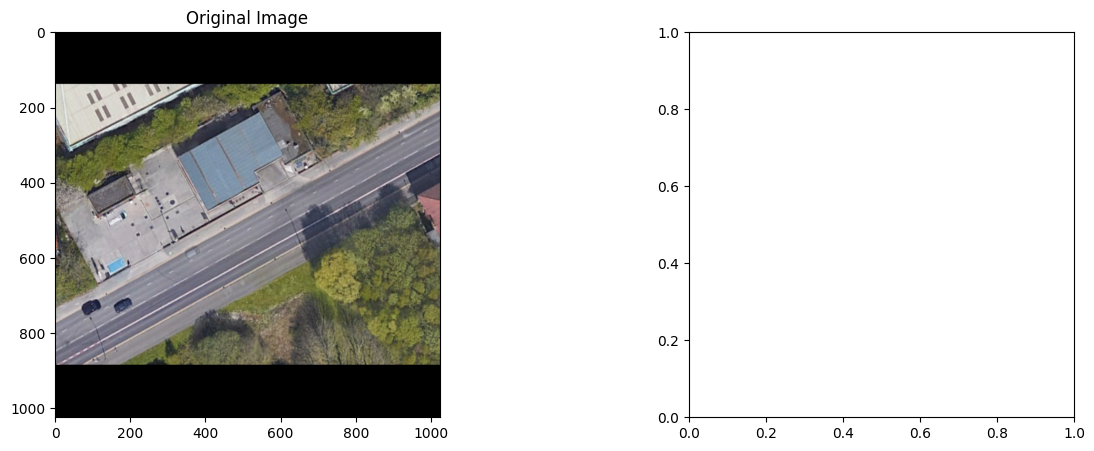

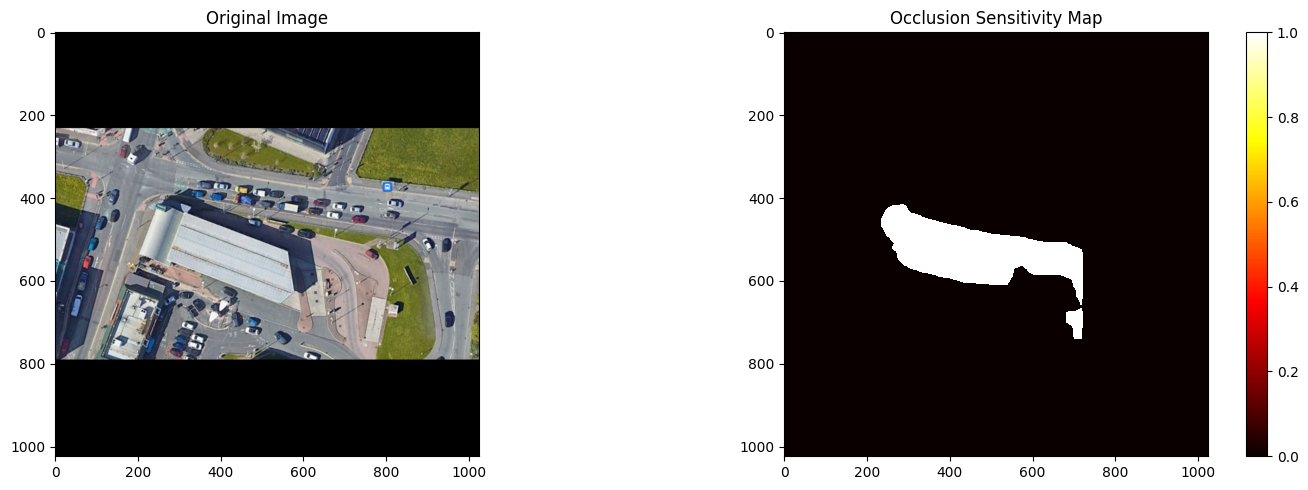

In [20]:
for image, occlusion_map in zip(images, occlusion_maps): 
    try: 
        plot_occlusion_maps(image, occlusion_map)
    except: 
        print("Oops")